In [2]:
from brainlit.utils import session
from brainlit.feature_extraction import *
import napari

In [3]:
url = "s3://mouse-light-viz/precomputed_volumes/brain1"
sess = session.NeuroglancerSession(url=url, url_segments=url+"_segments", mip=0)
SEGLIST=[101,103,106,107,109,11,111,112,115,11,12,120,124,126,127,129,13,132,133,136,137,14,140,141,142,143,144,145,146,147,149,150]

In [4]:
sess._get_voxel(2, 0)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s][3846942.8 3798232.2 4425521. ]



array([12876, 12477,  4477])

In [5]:
%%capture
nbr = NeighborhoodFeatures(url=url, size=3, offset=[25,25,25], segment_url=url+"_segments")
nbr.fit(seg_ids=SEGLIST, num_verts=10, file_path='demo', batch_size=10)

In [6]:
import glob, feather
feathers = glob.glob('*.feather')


for count, feather_file in enumerate(feathers):
    if count == 0:
        data = feather.read_dataframe(feather_file)
    else:
        df = feather.read_dataframe(feather_file)
        data = pd.concat([data, df])
data.shape

(640, 346)

In [7]:
data.head()

,Segment,Vertex,Label,0,1,2,3,4,5,6,...,333,334,335,336,337,338,339,340,341,342
0,120,5,1,12190,12661,12348,12338,12553,12594,12701,...,11858,12119,12584,12049,11702,12109,12070,11719,12088,12202
1,120,5,0,11917,12125,12109,12372,11926,12026,11888,...,11827,11699,11834,11689,11705,11866,12106,11716,11758,11641
2,120,6,1,12750,12887,14101,14055,14167,13980,12981,...,13195,12642,12309,15227,15641,15857,14803,13686,12706,12418
3,120,6,0,11883,11928,11906,12054,11949,11776,11843,...,11922,11728,12015,11696,11939,11754,11613,11776,11708,12019
4,120,7,1,19273,19707,16831,14588,13830,13398,12749,...,12422,12608,12193,12012,12133,12042,12551,12273,12483,12108


In [8]:
from sklearn.preprocessing import StandardScaler
X = data.iloc[:, 3:]
X = StandardScaler().fit_transform(X)

y = data["Label"]

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
clf = MLPClassifier(hidden_layer_sizes=4, activation="logistic", alpha=1, max_iter=1000).fit(X_train, y_train)
y_score = clf.predict_proba(X_test)

/Users/bijanvarjavand/miniconda3/envs/brainlit3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


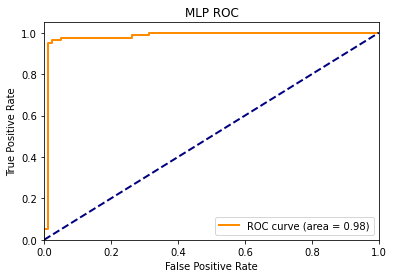

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC')
plt.legend(loc="lower right")
plt.show()

In [11]:
from brainlit.feature_extraction.neighborhood import subsample

In [12]:
from sklearn.linear_model import LogisticRegression
X_center = X[:, 172].reshape(-1,1)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y, stratify=y, random_state=1)
clf = LogisticRegression(random_state=1, max_iter=2000).fit(Xc_train, yc_train)
yc_score = clf.predict_proba(Xc_test)

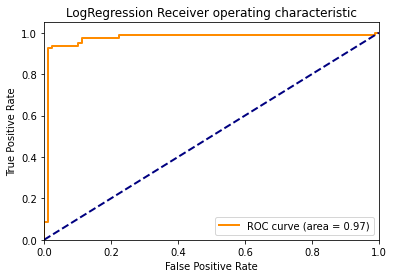

In [13]:
fpr_c, tpr_c, _ = roc_curve(yc_test, yc_score[:,1])
roc_auc_c = auc(fpr_c, tpr_c)

plt.figure()
lw = 2
plt.plot(fpr_c, tpr_c, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_c)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogRegression Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()